# Import Library

In [1]:
import pandas as pd
import duckdb
import os
import plotly.express as px


# Make eklipse_data.db

In [2]:
# Inisialisasi koneksi DuckDB (in-memory atau file)
con = duckdb.connect(database=':memory:')  # Atau ganti dengan 'database.duckdb' kalau ingin persist

# Load semua CSV sebagai view (DuckDB bisa baca langsung dari disk!)
con.execute("""
    CREATE VIEW downloaded_clips AS SELECT * FROM read_csv_auto('da_test/downloaded_clips.csv');
    CREATE VIEW shared_clips AS SELECT * FROM read_csv_auto('da_test/shared_clips.csv');
    CREATE VIEW clips AS SELECT * FROM read_csv_auto('da_test/clips.csv');
    CREATE VIEW premium_users AS SELECT * FROM read_csv_auto('da_test/premium_users.csv');
    CREATE VIEW gamesession AS SELECT * FROM read_csv_auto('da_test/gamesession.csv');
""")

## SQL

## Question SQL 1
The total number of users who have downloaded any clips. total number of clips downloaded. The total number of game sessions from which the downloaded clips were generated. 

In [3]:
query = """--sql 
SELECT
    COUNT(DISTINCT user_id) AS total_user_who_download_clips,
    COUNT(DISTINCT clip_id) AS total_clips_downloaded,
    COUNT(DISTINCT gamesession_id) AS total_gamesession_generated
FROM downloaded_clips dc;"""

df = con.execute(query).fetchdf()
df


,total_user_who_download_clips,total_clips_downloaded,total_gamesession_generated
0,1454,12935,4338


## Question SQL 2
For users who purchased premium in the last 3 months: Get the number of 
users who purchased premium, the number of users who shared any clips, 
the total number of clips shared, and the total number of gamesessions from 
which the shared clips were generated. 

In [4]:
query = """--sql 
WITH premiums_users_last_3_month AS (
    SELECT user_id
    FROM premium_users
    WHERE CAST(starts_at AS TIMESTAMP) >= (
        SELECT MAX(CAST(starts_at AS TIMESTAMP)) - INTERVAL '3 MONTH'
        FROM premium_users
    )
),
premium_summary AS (
    SELECT 
        COUNT(DISTINCT user_id) AS total_user_who_purchased_premium_last_3_months
    FROM premiums_users_last_3_month
),
shared_clips_summary AS (
    SELECT 
        COUNT(DISTINCT sc.user_id) AS number_of_user_premium_last_3_month_who_shared_clips,
        COUNT(DISTINCT sc.clip_id) AS number_of_clip_shared,
        COUNT(DISTINCT sc.gamesession_id) AS number_of_gamesession_generated_from_shared_clips
    FROM shared_clips sc
    JOIN premiums_users_last_3_month pul3m ON sc.user_id = pul3m.user_id
)

SELECT 
    ps.total_user_who_purchased_premium_last_3_months,
    scs.number_of_user_premium_last_3_month_who_shared_clips,
    scs.number_of_clip_shared,
    scs.number_of_gamesession_generated_from_shared_clips
FROM premium_summary ps
CROSS JOIN shared_clips_summary scs;

"""

df = con.execute(query).fetchdf()
df


,total_user_who_purchased_premium_last_3_months,number_of_user_premium_last_3_month_who_shared_clips,number_of_clip_shared,number_of_gamesession_generated_from_shared_clips
0,164,59,1144,359


## Question SQL 3
Calculate, on a weekly basis: The number of users engaged. The number of 
clips engaged. The total number of gamesessions from which the engaged 
clips were generated.

In [5]:
query = """--sql 
WITH premiums_users_last_3_month AS (
    SELECT user_id
    FROM premium_users
    WHERE starts_at >= (
        SELECT MAX(starts_at) - INTERVAL '3 MONTH'
        FROM premium_users
    )
),
premium_summary AS (
    SELECT 
        COUNT(DISTINCT user_id) AS total_user_who_purchased_premium_last_3_months
    FROM premiums_users_last_3_month
),
shared_clips_summary AS (
    SELECT 
        COUNT(DISTINCT sc.user_id) AS number_of_user_premium_last_3_month_who_shared_clips,
        COUNT(DISTINCT sc.clip_id) AS number_of_clip_shared,
        COUNT(DISTINCT sc.gamesession_id) AS number_of_gamesession_generated_from_shared_clips
    FROM shared_clips sc
    JOIN premiums_users_last_3_month pul3m ON sc.user_id = pul3m.user_id
)

SELECT 
    ps.total_user_who_purchased_premium_last_3_months,
    scs.number_of_user_premium_last_3_month_who_shared_clips,
    scs.number_of_clip_shared,
    scs.number_of_gamesession_generated_from_shared_clips
FROM premium_summary ps
CROSS JOIN shared_clips_summary scs;
"""

df = con.execute(query).fetchdf()
df


,total_user_who_purchased_premium_last_3_months,number_of_user_premium_last_3_month_who_shared_clips,number_of_clip_shared,number_of_gamesession_generated_from_shared_clips
0,164,59,1144,359


# B. Data Analysis

In [6]:
query_gamesession_premium_users = """--sql
-----------------------------------------------------------
-- query premium user ids
with gamession_with_premium_users as (
-- query gamesession who the user_id is premium
SELECT 
    *
FROM
    gamesession
WHERE
    user_id IN (SELECT DISTINCT user_id from premium_users)
)

select 
    count(distinct id) as total_gamesession_generated_by_premium_users,
    count(distinct user_id) as total_premium_users_who_generated_gamesession,
    round(avg(duration)/1000,2) as average_duration_gamesession_per_premium_users,
    count(distinct game_name) as total_games_used_by_premium_users_to_process_gamesession  

from 
    gamession_with_premium_users
-----------------------------------------------------------
"""

query_gamesession_free_users = """--sql
-----------------------------------------------------------
-- query free user ids
with gamession_with_free_users as (
-- query gamesession who the user_id is free
SELECT 
    *
FROM
    gamesession
WHERE
    user_id NOT IN (SELECT DISTINCT user_id from premium_users)
)

select 
    count(distinct id) as total_gamesession_generated_by_free_users,
    count(distinct user_id) as total_free_users_who_generated_gamesession,
    round(avg(duration)/1000,2) as average_duration_gamesession_per_free_users,
    count(distinct game_name) as total_games_used_by_free_users_to_process_gamesession
from 
    gamession_with_free_users
-----------------------------------------------------------
"""

df_premium_users = con.execute(query_gamesession_premium_users).fetchdf()
df_free_users = con.execute(query_gamesession_free_users).fetchdf()

df_free_users

,total_gamesession_generated_by_free_users,total_free_users_who_generated_gamesession,average_duration_gamesession_per_free_users,total_games_used_by_free_users_to_process_gamesession
0,28524,4002,6959.48,57


## Gamessesion

### Compare free and premium users based on the gamesessions created by users


In [7]:
query = """--sql
----------------------------------------------------------------------------------------------
with gamesession_with_user_type as (
SELECT 
    g.*,
    CASE 
        WHEN g.user_id IN (SELECT DISTINCT user_id FROM premium_users) THEN 'premium'
        ELSE 'free'
    END AS user_type
FROM 
    gamesession g
)

select
    user_type, 
    count(distinct id) as total_gamesession_generated,
    count(distinct user_id) as total_users_who_generated_gamesession,
    round(avg(duration),0) as average_duration_gamesession,
    count(distinct game_name) as total_games_used_to_process_gamesession,
    
from 
    gamesession_with_user_type
group by user_type
----------------------------------------------------------------------------------------------
"""
df_agg_gamession_by_user_type = con.execute(query).fetchdf()


df_agg_gamession_by_user_type

,user_type,total_gamesession_generated,total_users_who_generated_gamesession,average_duration_gamesession,total_games_used_to_process_gamesession
0,free,28524,4002,6959485.0,57
1,premium,9055,320,10506121.0,53


In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Buat subplot 2x2
fig = make_subplots(rows=2, cols=2, subplot_titles=[
    "Total GameSessions",
    "Total Users",
    "Average Duration (sec)",
    "Total Games Used"
])

# Bar chart 1: Total GameSessions
fig.add_trace(go.Bar(
    x=df_agg_gamession_by_user_type['user_type'],
    y=df_agg_gamession_by_user_type['total_gamesession_generated'],
    name='Total GameSessions',
    marker_color='indianred'
), row=1, col=1)

# Bar chart 2: Total Users
fig.add_trace(go.Bar(
    x=df_agg_gamession_by_user_type['user_type'],
    y=df_agg_gamession_by_user_type['total_users_who_generated_gamesession'],
    name='Total Users',
    marker_color='lightsalmon'
), row=1, col=2)

# Bar chart 3: Average Duration
fig.add_trace(go.Bar(
    x=df_agg_gamession_by_user_type['user_type'],
    y=df_agg_gamession_by_user_type['average_duration_gamesession'],
    name='Avg Duration',
    marker_color='dodgerblue'
), row=2, col=1)

# Bar chart 4: Total Games Used
fig.add_trace(go.Bar(
    x=df_agg_gamession_by_user_type['user_type'],
    y=df_agg_gamession_by_user_type['total_games_used_to_process_gamesession'],
    name='Games Used',
    marker_color='mediumseagreen'
), row=2, col=2)

# Update layout
fig.update_layout(
    title_text="Comparison Between Free vs Premium Users",
    showlegend=False,
    height=600,
    width=900
)

fig.show()


We can observe that the total number of gamesessions created and the number of games played are higher among free users compared to premium users. This is expected, as the number of free users who create gamesessions is significantly greater than that of premium users. However, an interesting insight is that premium users tend to create gamesessions with much longer durations compared to free users.

### Compare free and premium users based on the gamesessions created by users for each game.

In [9]:
query = """--sql
WITH gamesession_with_user_type AS (
    SELECT 
        g.*,
        CASE 
            WHEN g.user_id IN (SELECT DISTINCT user_id FROM premium_users) THEN 'premium'
            ELSE 'free'
        END AS user_type
    FROM 
        gamesession g
),
agg AS (
    SELECT 
        user_type, 
        game_name,
        COUNT(DISTINCT id) AS total_gamesession_generated,
        COUNT(DISTINCT user_id) AS total_users_who_generated_gamesession,
        ROUND(AVG(duration), 0) AS average_duration_gamesession
    FROM gamesession_with_user_type
    GROUP BY user_type, game_name
)

SELECT 
    *,
    ROUND(
        total_gamesession_generated * 100.0 
        / SUM(total_gamesession_generated) OVER (PARTITION BY user_type), 
        2
    ) AS pct_gamesession_within_user_type,
    ROUND(
        total_users_who_generated_gamesession * 100.0 
        / SUM(total_users_who_generated_gamesession) OVER (PARTITION BY user_type), 
        2
    ) AS pct_users_within_user_type
FROM agg
ORDER BY user_type, pct_gamesession_within_user_type DESC


---order by user_type, total_gamesession_generated DESC
"""

df_agg_gamession_by_user_type_per_game = con.execute(query).fetchdf()
df_agg_gamession_by_user_type_per_game.head(5)

,user_type,game_name,total_gamesession_generated,total_users_who_generated_gamesession,average_duration_gamesession,pct_gamesession_within_user_type,pct_users_within_user_type
0,free,Other Games,10938,2233,7562694.0,38.35,32.11
1,free,COD: Warzone3-2 & MW3-2,5655,983,6154490.0,19.83,14.14
2,free,Fortnite,3213,807,6394120.0,11.26,11.60
3,free,Valorant,1977,388,8528200.0,6.93,5.58
4,free,Apex Legends,1413,303,7047973.0,4.95,4.36


In [10]:
import plotly.express as px

df_filtered = df_agg_gamession_by_user_type_per_game[~df_agg_gamession_by_user_type_per_game['game_name'].isnull()]


fig = px.bar(
    df_filtered,
    x='pct_gamesession_within_user_type',
    y='game_name',
    color='user_type',
    orientation='h',
    text='pct_gamesession_within_user_type',
    barmode='group',
    title='Percent of Total GameSessions per Game (Free vs Premium) - Horizontal',
    labels={
        "pct_gamesession_within_user_type": "Percent of Total GameSessions",
        "game_name": "Game",
        "user_type": "User Type"
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    height=800,
    width=1000,
    margin=dict(l=150, t=80),
    yaxis=dict(categoryorder='total ascending') 
)

fig.show()

######################################################################################
fig = px.bar(
    df_filtered,
    x='pct_users_within_user_type',
    y='game_name',
    color='user_type',
    orientation='h',
    text='pct_users_within_user_type',
    barmode='group',
    title='Percent of Total Users who Generated GameSessions per Game (Free vs Premium) - Horizontal',
    labels={
        "pct_users_within_user_type": "Percent of Total Users",
        "game_name": "Game",
        "user_type": "User Type"
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    height=800,
    width=1000,
    margin=dict(l=150, t=80),
    yaxis=dict(categoryorder='total ascending') 
)

fig.show()

######################################################################################
fig = px.bar(
    df_filtered,
    x='average_duration_gamesession',
    y='game_name',
    color='user_type',
    orientation='h',
    text='average_duration_gamesession',
    barmode='group',
    title='Average Duration of GameSessions per Game (Free vs Premium) - Horizontal',
    labels={
        "average_duration_gamesession": "Duration",
        "game_name": "Game",
        "user_type": "User Type"
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    height=800,
    width=1000,
    margin=dict(l=150, t=80),
    yaxis=dict(categoryorder='total ascending') 
)

fig.show()


## Clips

### Compare free and premium users based on the clips created by users


#### query

In [11]:
query_clips_by_user_type = """--sql
SELECT 
    c.*,
    CASE 
        WHEN c.user_id IN (SELECT DISTINCT user_id FROM premium_users) THEN 'premium'
        ELSE 'free'
    END AS user_type
FROM 
    clips c
"""

query_aggregate = f"""--sql
----------------------------------------------------------------------------------------------
with clips_with_user_type as (
{query_clips_by_user_type}
)

select
    user_type, 
    count(distinct id) as total_clips_created,
    count(distinct user_id) as total_users_whose_clips_created,
    cast(round(avg(duration),0) as integer) as average_duration_clips,
    count(distinct game_name) as total_games_used_for_creating_clips,
    count(distinct event_name) as total_event,
    cast(round(count(distinct id) / count(distinct user_id),0) as integer) as average_clips_per_user
    
from 
    clips_with_user_type
group by user_type
----------------------------------------------------------------------------------------------
"""

query_duration_distribution = f"""--sql
with clips_with_user_type as (
{query_clips_by_user_type}
)

select
    user_type, 
    count(distinct id) as total_clips_created,
    count(distinct user_id) as total_users_whose_clips_created,
 
     
"""

query_clips_premium_user = f"""--sql
with clips_with_user_type as (
{query_clips_by_user_type}
)

select * from clips_with_user_type where user_type = 'premium'
"""

query_clips_free_user = f"""--sql
with clips_with_user_type as (
{query_clips_by_user_type}
)

select * from clips_with_user_type where not user_type = 'premium'
"""

df_clips = con.execute(query_clips_by_user_type).fetchdf()
df_clips_premium_user = con.execute(query_clips_premium_user).fetchdf()
df_clips_free_user = con.execute(query_clips_free_user).fetchdf()

df_clips_agg_by_user_type = con.execute(query_aggregate).fetchdf()

df_clips_agg_by_user_type


,user_type,total_clips_created,total_users_whose_clips_created,average_duration_clips,total_games_used_for_creating_clips,total_event,average_clips_per_user
0,free,361391,4239,61,53,106,85
1,premium,190640,324,48,53,101,588


#### Charts

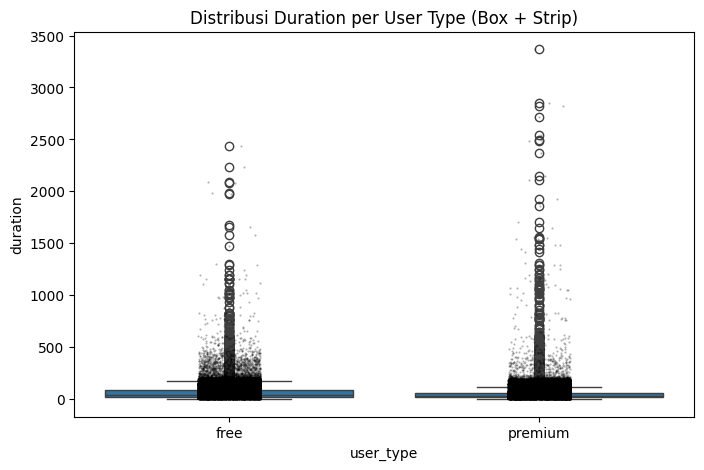

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Buat subplot 2x2
fig = make_subplots(rows=3, cols=2, subplot_titles=[
    "Total Clips Created",
    "Total Users Whose Clips Created",
    "Average Duration Clips (sec)",
    "Total Games Used For Creating Clips",
    "Average Clips per User",
])

# Bar chart 1: Total Clips Created
fig.add_trace(go.Bar(
    x=df_clips_agg_by_user_type['user_type'],
    y=df_clips_agg_by_user_type['total_clips_created'],
    name='Total Clips',
    marker_color='indianred'
), row=1, col=1)

# Bar chart 2: Total Users
fig.add_trace(go.Bar(
    x=df_clips_agg_by_user_type['user_type'],
    y=df_clips_agg_by_user_type['total_users_whose_clips_created'],
    name='Total Users',
    marker_color='lightsalmon'
), row=1, col=2)

# Bar chart 3: Average Duration
fig.add_trace(go.Bar(
    x=df_clips_agg_by_user_type['user_type'],
    y=df_clips_agg_by_user_type['average_duration_clips'],
    name='Avg Duration',
    marker_color='dodgerblue'
), row=2, col=1)

# Bar chart 4: Total Games Used
fig.add_trace(go.Bar(
    x=df_clips_agg_by_user_type['user_type'],
    y=df_clips_agg_by_user_type['total_games_used_for_creating_clips'],
    name='Games Used',
    marker_color='mediumseagreen'
), row=2, col=2)

# Bar chart 5: Average Clips per User 
fig.add_trace(go.Bar(
    x=df_clips_agg_by_user_type['user_type'],
    y=df_clips_agg_by_user_type['average_clips_per_user'],
    name='Average Clips',
    marker_color='mediumseagreen'
), row=3, col=1)


# Update layout
fig.update_layout(
    title_text="Comparison Between Free vs Premium Users",
    showlegend=False,
    height=900,
    width=900
)

fig.show()
#################################
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clips, x="user_type", y="duration")
sns.stripplot(data=df_clips, x="user_type", y="duration", color='black', size=1.5, jitter=True, alpha=0.3)
plt.title("Distribusi Duration per User Type (Box + Strip)")
plt.show()


We can observe that the total number of gamesessions created and the number of games played are higher among free users compared to premium users. This is expected, as the number of free users who create gamesessions is significantly greater than that of premium users. However, an interesting insight is that premium users tend to create gamesessions with much longer durations compared to free users.

### Compare free and premium users based on the gamesessions created by users for each game.

#### query

In [55]:
query = """--sql
WITH clip_with_user_type AS (
    SELECT 
        c.*,
        CASE 
            WHEN c.user_id IN (SELECT DISTINCT user_id FROM premium_users) THEN 'premium'
            ELSE 'free'
        END AS user_type
    FROM 
        clips c
),
agg AS (
    SELECT 
        user_type,
        game_name, 
        count(distinct id) as total_clips_created,
        count(distinct user_id) as total_users_whose_clips_created,
        cast(round(avg(duration),0) as integer) as average_duration_clips,
        count(distinct event_name) as total_event,
        cast(round(count(distinct id) / count(distinct user_id),0) as integer) as average_clips_per_user
    FROM clip_with_user_type
    GROUP BY user_type, game_name
)

SELECT 
    *,
    ROUND(
        total_clips_created * 100.0 
        / SUM(total_clips_created) OVER (PARTITION BY user_type), 
        2
    ) AS percentage_clips,
    ROUND(
        total_users_whose_clips_created * 100.0 
        / SUM(total_users_whose_clips_created) OVER (PARTITION BY user_type), 
        2
    ) AS percentage_users_whose_clips_created,
    ROUND(
        total_event * 100.0 
        / SUM(total_event) OVER (PARTITION BY user_type), 
        2
    ) AS percentage_event 
FROM agg
ORDER BY user_type, percentage_users_whose_clips_created DESC


---order by user_type, total_user_generated DESC
"""

df_agg_clip_by_user_type_per_game = con.execute(query).fetchdf()
df_agg_clip_by_user_type_per_game.head(5)

,user_type,game_name,total_clips_created,total_users_whose_clips_created,average_duration_clips,total_event,average_clips_per_user,percentage_clips,percentage_users_whose_clips_created,percentage_event
0,free,Other Games,96995,2177,104,8,45,26.84,27.22,4.30
1,free,None,10091,1299,34,0,8,2.79,16.24,0.00
2,free,COD: Warzone3-2 & MW3-2,79418,971,49,17,82,21.98,12.14,9.14
3,free,Fortnite,46749,802,37,9,58,12.94,10.03,4.84
4,free,Podcast,10288,448,61,1,23,2.85,5.60,0.54


#### Charts

In [94]:
import plotly.express as px
import itertools

columns_corr = [
    'total_clips_created',
    'total_users_whose_clips_created',
    'average_duration_clips',
    'total_event',
    'average_clips_per_user'
]

# Buat semua pasangan kolom unik (tanpa duplikat dan kolom sama)
pairs = list(itertools.combinations(columns_corr, 2))

# Loop untuk buat scatter plot semua pasangan
for x_col, y_col in pairs:
    fig = px.scatter(
        df_agg_clip_by_user_type_per_game,
        x=x_col,
        y=y_col,
        color="user_type",
        trendline="ols",
        trendline_scope="trace",
        hover_data=["game_name"],
        title=f"Scatter Plot: {x_col} vs {y_col} per Game"
    )

    fig.show()


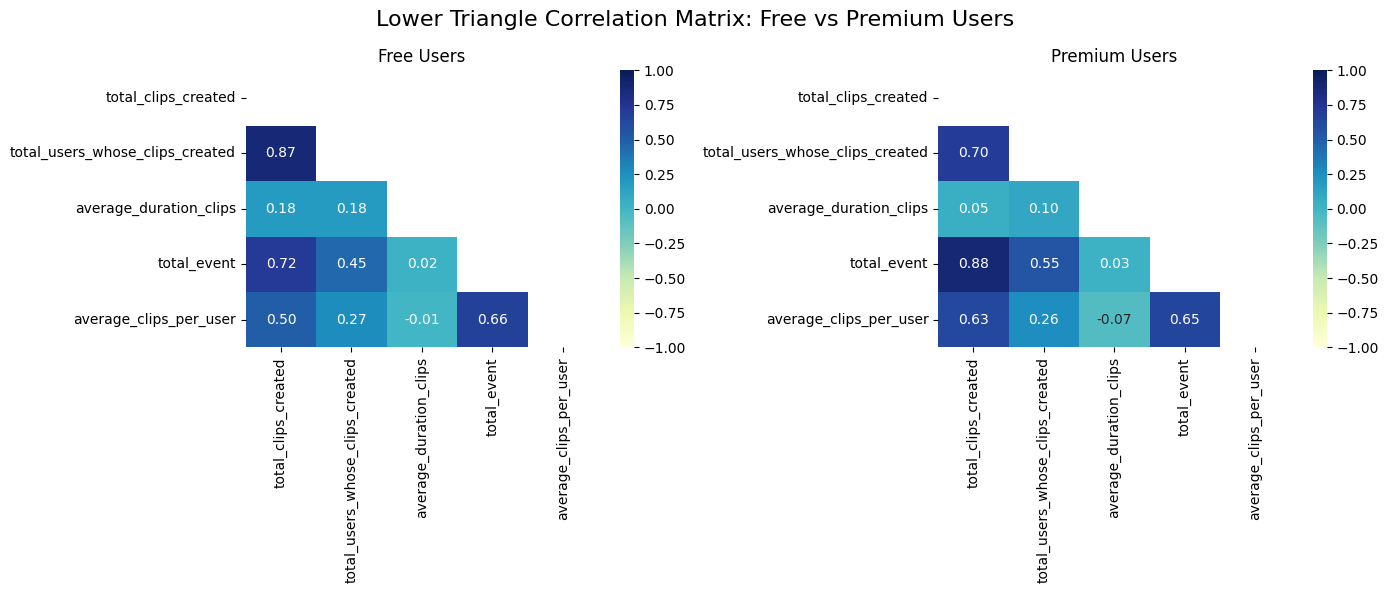

In [93]:
import numpy as np
import plotly.graph_objects as go

columns_corr = [
    'total_clips_created',
    'total_users_whose_clips_created',
    'average_duration_clips',
    'total_event',
    'average_clips_per_user'
]

# Buat subset data
df_free = df_agg_clip_by_user_type_per_game[df_agg_clip_by_user_type_per_game['user_type'] == 'free']
df_premium = df_agg_clip_by_user_type_per_game[df_agg_clip_by_user_type_per_game['user_type'] == 'premium']

# Fungsi bantu: ambil korelasi dan masking segitiga atas
def get_lower_triangle_corr(df, columns):
    corr = df[columns].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    return corr, mask

# Hitung korelasi dan mask
corr_free, mask_free = get_lower_triangle_corr(df_free, columns_corr)
corr_premium, mask_premium = get_lower_triangle_corr(df_premium, columns_corr)

# Buat subplot 1 baris 2 kolom
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Free
sns.heatmap(corr_free, mask=mask_free, annot=True, fmt=".2f", cmap="YlGnBu",
            vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Free Users")

# Plot Premium
sns.heatmap(corr_premium, mask=mask_premium, annot=True, fmt=".2f", cmap="YlGnBu",
            vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Premium Users")

plt.suptitle("Lower Triangle Correlation Matrix: Free vs Premium Users", fontsize=16)
plt.tight_layout()
plt.show()


In [85]:
import plotly.express as px

df_filtered = df_agg_clip_by_user_type_per_game[~df_agg_clip_by_user_type_per_game['game_name'].isnull()]


fig = px.bar(
    df_filtered,
    x='percentage_clips',
    y='game_name',
    color='user_type',
    orientation='h',
    text='percentage_clips',
    barmode='group',
    title='Percent of Total Clips per Game (Free vs Premium) - Horizontal',
    labels={
        "percentage_clips": "Percent of Total Clips",
        "game_name": "Game",
        "user_type": "User Type"
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    height=800,
    width=1000,
    margin=dict(l=150, t=80),
    yaxis=dict(categoryorder='total ascending') 
)

fig.show()

######################################################################################
fig = px.bar(
    df_filtered,
    x='percentage_users_whose_clips_created',
    y='game_name',
    color='user_type',
    orientation='h',
    text='percentage_users_whose_clips_created',
    barmode='group',
    title='Percent of Total Users whose Clips Generated per Game (Free vs Premium) - Horizontal',
    labels={
        "percentage_users_whose_clips_created": "Percent of Total Users",
        "game_name": "Game",
        "user_type": "User Type"
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    height=800,
    width=1000,
    margin=dict(l=150, t=80),
    yaxis=dict(categoryorder='total ascending') 
)

fig.show()

######################################################################################
fig = px.bar(
    df_filtered,
    x='percentage_event',
    y='game_name',
    color='user_type',
    orientation='h',
    text='percentage_event',
    barmode='group',
    title='Percent of Total Event whose Clips Generated per Game (Free vs Premium) - Horizontal',
    labels={
        "percentage_event": "Percent of Total Event",
        "game_name": "Game",
        "user_type": "User Type"
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    height=800,
    width=1000,
    margin=dict(l=150, t=80),
    yaxis=dict(categoryorder='total ascending') 
)

fig.show()
######################################################################################
fig = px.bar(
    df_filtered,
    x='average_clips_per_user',
    y='game_name',
    color='user_type',
    orientation='h',
    text='average_clips_per_user',
    barmode='group',
    title='Average Duration of Clips per Game (Free vs Premium) - Horizontal',
    labels={
        "average_clips_per_user": "Duration (in seconds)",
        "game_name": "Game",
        "user_type": "User Type"
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    height=800,
    width=1000,
    margin=dict(l=150, t=80),
    yaxis=dict(categoryorder='total ascending') 
)

fig.show()

######################################################################################